# Implications from legacy device environments on the conceptional design of machine learning models in manufacturing

## Combined approach

This notebook contains all the preliminary models used in the OBerA project.
It belongs to the article "DImplications from legacy device environments on the conceptional design of machine learning models in manufacturing" 

# Imports


In [1]:
# Importing libraries
import pandas as pd #for working with dataframes
import numpy as np #for numerical and vector operations
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization
import lightgbm as lgb #for light gradient boosting machine
import xgboost as xgb #for extreme gradient boosting 


# Metrics
from sklearn import metrics #metrics
from sklearn.metrics import classification_report #for F1 score and other metrics
from sklearn.metrics import f1_score #for F1 score specifically
from sklearn.metrics import matthews_corrcoef #for Matthews correlation coefficient (MCC)
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import roc_curve, roc_auc_score #ROC and AUC scores
from sklearn.metrics import ConfusionMatrixDisplay #for plotting confusion matrix

# Importing machine learning tools for preprocessing
from sklearn.model_selection import train_test_split #for splitting the data into training and test sets
from sklearn.preprocessing import StandardScaler #for feature scaling

# Models

from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.ensemble import ExtraTreesClassifier #extra trees classifier

from catboost import CatBoostClassifier #cat boost classifier

# Function definition

Here we define a few functions that will be used to evaluate the models.


## ROC curve function
 

In [2]:
# Define the ROC curve function with graphical output

def plot_roc_curve(model):

    #setting up the parameters
    try:
        probs = model.predict(test_features)
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
    except ValueError: #this is needed for Neural Network
        probs = np.argmax(model.predict(test_features, batch_size=1, verbose=0), axis=-1)
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
        
    #plotting the ROC curve
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    #print AUC score
    print(f"AUC score: {roc_auc_score(test_labels, probs)}")

In [3]:
# Import data from csv
data = pd.read_csv("Data_Detecting_Changeover.csv", sep= ',',header=0, index_col=0)
data.head()

,DateTime,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Phase,Phase_compressed,Production
0,2021-12-07 07:39:24,2.0,0.0,0.0,1.0,0.0,45.0,3600.0,1999.0,-0.445,1.205,7,1,0
11271,2021-12-07 07:39:25,2.0,0.0,0.0,1.0,0.0,45.0,3600.0,1999.0,-0.412,1.203,7,1,0
1,2021-12-07 07:39:26,2.0,0.0,0.0,1.0,0.0,45.0,3600.0,1999.0,-0.327,1.221,7,1,0
11272,2021-12-07 07:39:27,2.0,0.0,0.0,1.0,0.0,45.0,3600.0,2000.0,-0.297,1.251,7,1,0
2,2021-12-07 07:39:28,2.0,0.0,0.0,1.0,0.0,45.0,3600.0,1999.0,-0.265,1.259,7,1,0


In [4]:
print(data.describe())

       ProgramStatus    ToolNumber   PocketTable   DriveStatus  \
count   21940.000000  21940.000000  21940.000000  21940.000000   
mean        1.439107     11.023473      4.698952      0.541796   
std         1.634662      8.434492      7.231461      0.498261   
min         0.000000      0.000000      0.000000      0.000000   
25%         0.000000      8.000000      0.000000      0.000000   
50%         2.000000      8.000000      1.000000      1.000000   
75%         2.000000     19.000000      8.000000      1.000000   
max         6.000000     32.000000     30.000000      1.000000   

       DoorStatusTooling  OverrideFeed      FeedRate  SpindleSpeed  \
count       21940.000000  21940.000000  21940.000000  21940.000000   
mean            0.039107     85.174878    607.645138   1828.052735   
std             0.193853     33.112375   3269.363502   2594.748294   
min             0.000000      0.000000 -32590.000000      0.000000   
25%             0.000000     84.000000      0.000000   

# Removing unnecessary columns

We need to ensure that our data contains entries useful for binary classification only. Everything else has to be discarded.


In [5]:
# Dropping the columns we do not need
df = data.copy()
df.pop('DateTime')
df.pop('Phase')
df.pop('Phase_compressed')
print(df)

       ProgramStatus  ToolNumber  PocketTable  DriveStatus  DoorStatusTooling  \
0                2.0         0.0          0.0          1.0                0.0   
11271            2.0         0.0          0.0          1.0                0.0   
1                2.0         0.0          0.0          1.0                0.0   
11272            2.0         0.0          0.0          1.0                0.0   
2                2.0         0.0          0.0          1.0                0.0   
...              ...         ...          ...          ...                ...   
2253             2.0         3.0          3.0          1.0                0.0   
2254             2.0         3.0          3.0          1.0                0.0   
2255             2.0         3.0          3.0          1.0                0.0   
2256             2.0         3.0          3.0          1.0                0.0   
2257             2.0         3.0          3.0          1.0                0.0   

       OverrideFeed  FeedRa

# Data description


In [6]:
# Using the describe function to get 'raw' insights
df.describe()

,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Production
count,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000
mean,1.439107,11.023473,4.698952,0.541796,0.039107,85.174878,607.645138,1828.052735,-0.483395,1.451060,0.534549
std,1.634662,8.434492,7.231461,0.498261,0.193853,33.112375,3269.363502,2594.748294,0.288393,0.948068,0.498816
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32590.000000,0.000000,-1.416000,-1.103000,0.000000
25%,0.000000,8.000000,0.000000,0.000000,0.000000,84.000000,0.000000,0.000000,-0.702000,0.622000,0.000000
50%,2.000000,8.000000,1.000000,1.000000,0.000000,100.000000,0.000000,0.000000,-0.486000,1.510000,1.000000
75%,2.000000,19.000000,8.000000,1.000000,0.000000,100.000000,310.000000,4599.000000,-0.270000,1.914000,1.000000
max,6.000000,32.000000,30.000000,1.000000,1.000000,150.000000,32732.000000,10046.000000,0.220000,5.104000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

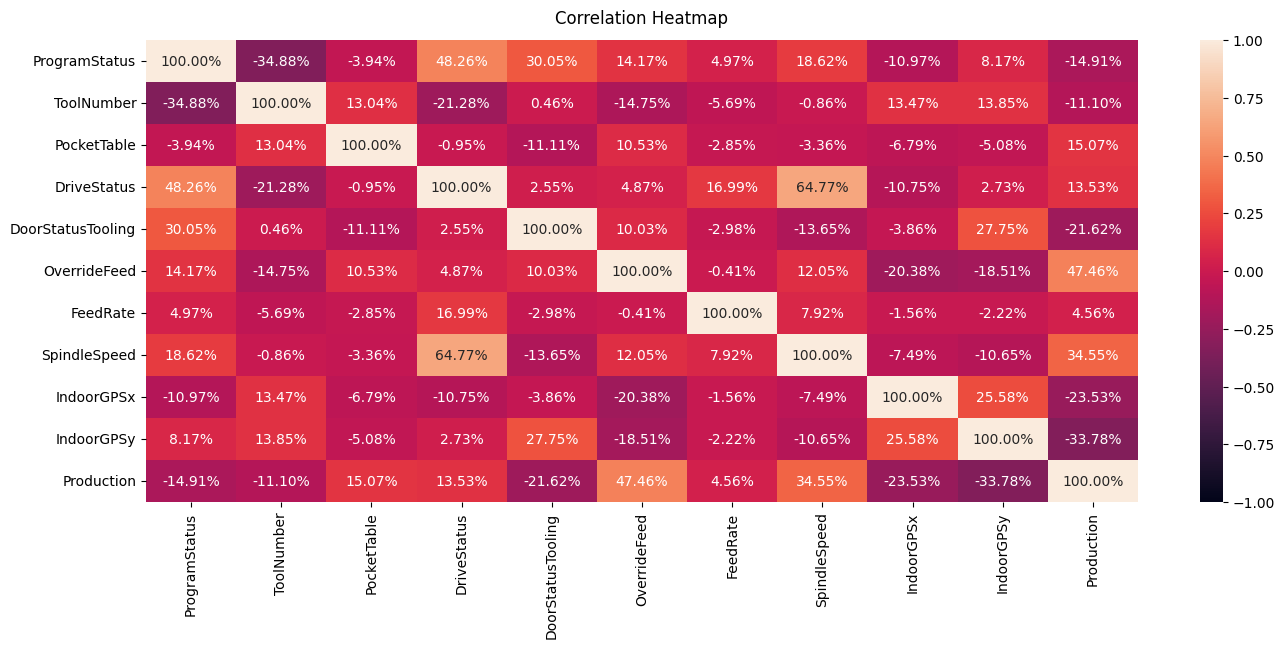

In [7]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2%')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


# Data preparation


In [8]:
# Splitting the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Using numpy to create arrays of lables and features
train_labels = np.array(train_df['Production'])
test_labels = np.array(test_df['Production'])
train_features = np.array(train_df.iloc[:, 0:10])
test_features = np.array(test_df.iloc[:, 0:10])

# Scaling the features using Standard Scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Having a look at the results
print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (17552,)
Test labels shape: (4388,)
Training features shape: (17552, 10)
Test features shape: (4388, 10)


In [9]:
train_labels

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

# Random Forest

Parameters didn't change after tuning

In [10]:
# Create a Random Forest classifier object
clf_RF = RandomForestClassifier(random_state=0)

# Train the Random Forest Classifier
clf_RF = clf_RF.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_RF = clf_RF.predict(test_features)

In [11]:
# Get the metrics for the Random Tree
print(classification_report(test_labels,y_pred_RF))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2101
           1       1.00      1.00      1.00      2287

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [12]:
# Get macro average F1 score
f1_RF = f1_score(test_labels, y_pred_RF, average='macro')
f1_RF

0.9963469863469863

In [13]:
# Calculate Matthews Correlation coefficient
MCC_RF = matthews_corrcoef(test_labels, y_pred_RF)
MCC_RF

0.992694388183797

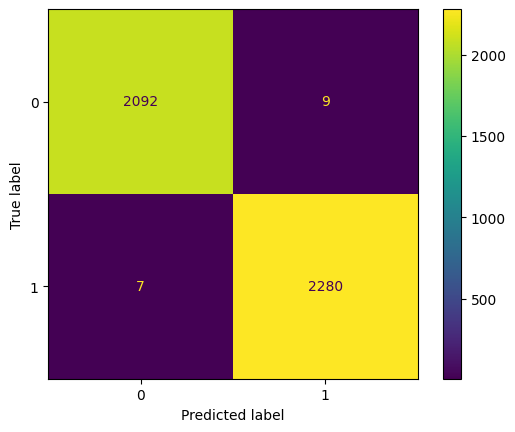

In [14]:
# Plot the confusion matrix for the Random Forest
cm=confusion_matrix(test_labels,y_pred_RF,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

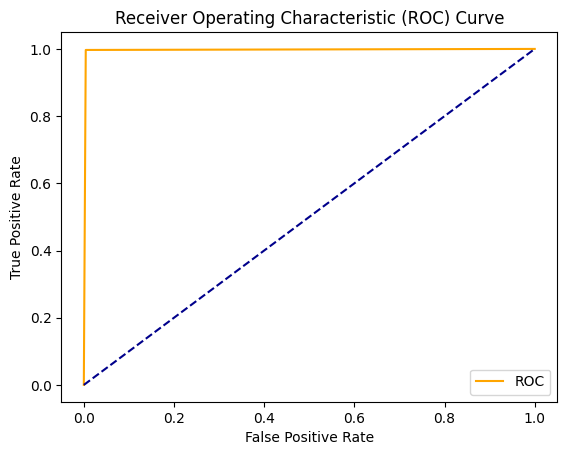

AUC score: 0.9963277736235291


In [15]:
# Plot the ROC curve and get the AUC score for the Random Forest
plot_roc_curve(clf_RF)

# Extra trees

Parameters didn't change after tuning


In [16]:
# Create an Extra Trees classifier object
clf_ET = ExtraTreesClassifier(n_jobs=-1,random_state=0)


clf_ET = clf_ET.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_ET = clf_ET.predict(test_features)

In [17]:
# Get the metrics for the Extra Trees
print(classification_report(test_labels,y_pred_ET))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2101
           1       1.00      1.00      1.00      2287

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [18]:
# Get macro average F1 score
f1_ET = f1_score(test_labels, y_pred_ET, average='macro')
f1_ET

0.9963469863469863

In [19]:
# Calculate Matthews Correlation coefficient
MCC_ET = matthews_corrcoef(test_labels, y_pred_ET)
MCC_ET

0.992694388183797

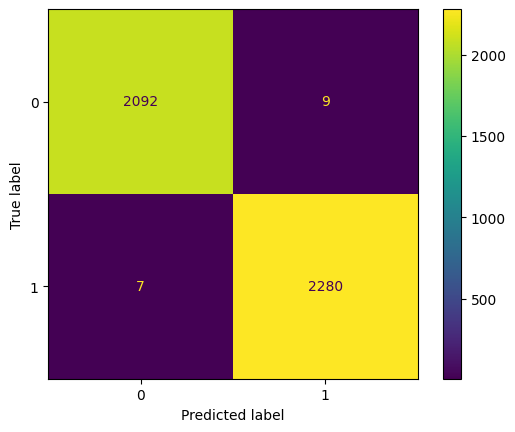

In [20]:
# Plot the confusion matrix for the Extra Trees
cm=confusion_matrix(test_labels,y_pred_ET,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

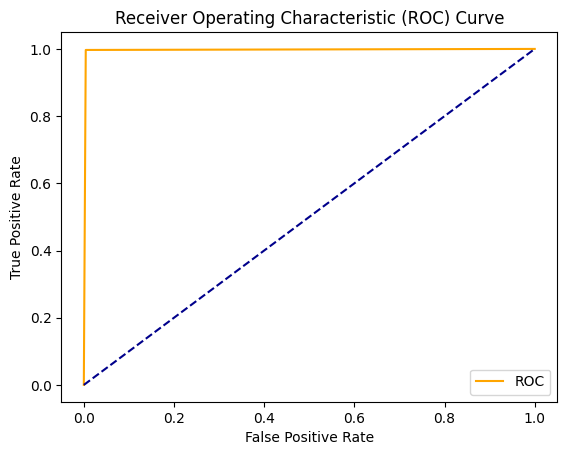

AUC score: 0.9963277736235291


In [21]:
# Plot the ROC curve and get the AUC score for the Extra Trees
plot_roc_curve(clf_ET)

# Cat Boost

In [24]:
# Create an CatBoost classifier object
clf_cat = CatBoostClassifier(iterations=260, depth=9, loss_function='Logloss', random_seed=0, 
                             random_strength=0.7,eta=0.3, sampling_frequency='PerTree')
# Train CatBoost Classifier
clf_cat.fit(train_features, train_labels, verbose=False)

In [25]:
# Predict the response for the test dataset
y_pred_cat = clf_cat.predict(test_features)
y_pred_cat

array([1, 1, 1, ..., 1, 1, 0])

In [26]:
# Get the metrics for the CatBoost
print(classification_report(test_labels,y_pred_cat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2101
           1       1.00      1.00      1.00      2287

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [27]:
# Get macro average F1 score
f1_CAT= f1_score(test_labels, y_pred_cat, average='macro')
f1_CAT

0.9956621309264122

In [28]:
# Calculate Matthews Correlation coefficient
MCC_CAT = matthews_corrcoef(test_labels, y_pred_cat)
MCC_CAT

0.9913243656496925

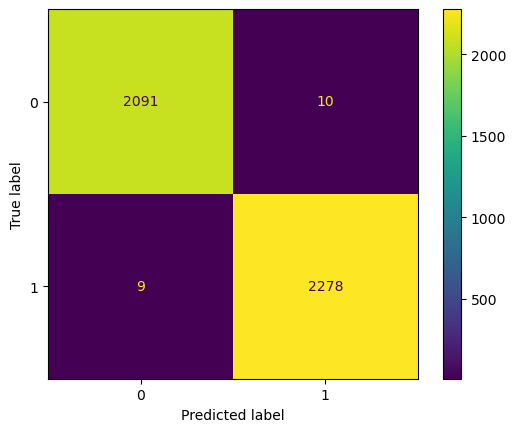

In [29]:
# Plot the confusion matrix for CatBoost
cm=confusion_matrix(test_labels,y_pred_cat,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

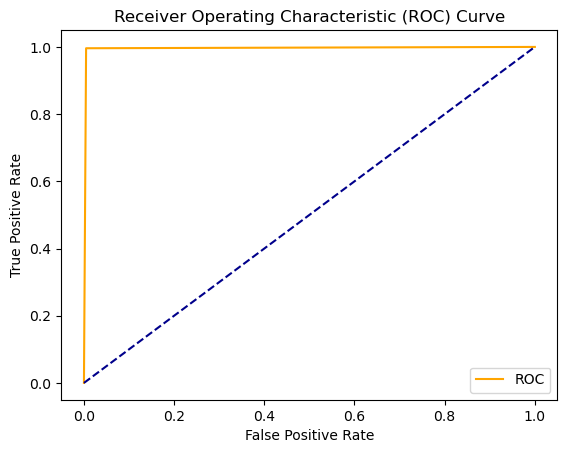

AUC score: 0.9956525376655545


In [30]:
# Plot the ROC curve and get the AUC score for CatBoost
plot_roc_curve(clf_cat)

# LightGBM 

Parameter didn't change after tuning

In [31]:
# Create an LightGBM classifier object
clf_gbm=lgb.LGBMClassifier(random_state=0)

# Train LightGBM Classifier
clf_gbm.fit(train_features,train_labels)

[LightGBM] [Info] Number of positive: 9441, number of negative: 8111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 17552, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537887 -> initscore=0.151841
[LightGBM] [Info] Start training from score 0.151841


LGBMClassifier(random_state=0)

In [32]:
# Predict the response for the test dataset
y_pred_gbm = clf_gbm.predict(test_features)
y_pred_gbm

array([1, 1, 1, ..., 1, 1, 0])

In [33]:
# Get the metrics for the LightGBM
print(classification_report(test_labels,y_pred_gbm))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2101
           1       1.00      1.00      1.00      2287

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [34]:
# Get macro average F1 score
f1_GBM = f1_score(test_labels, y_pred_gbm, average='macro')
f1_GBM

0.9952055131291926

In [35]:
# Calculate Matthews Correlation coefficient
MCC_GBM = matthews_corrcoef(test_labels, y_pred_gbm)
MCC_GBM

0.9904111300075642

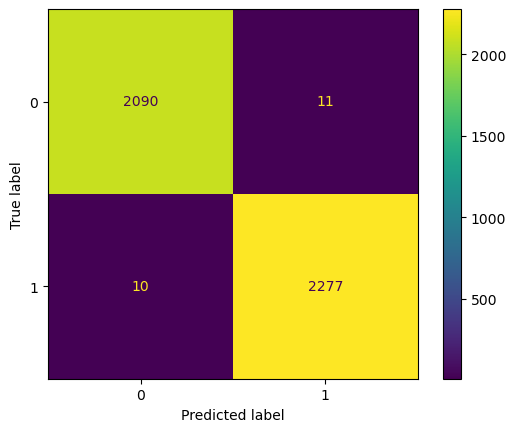

In [36]:
# Plot the confusion matrix for LightGBM
cm=confusion_matrix(test_labels,y_pred_gbm,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

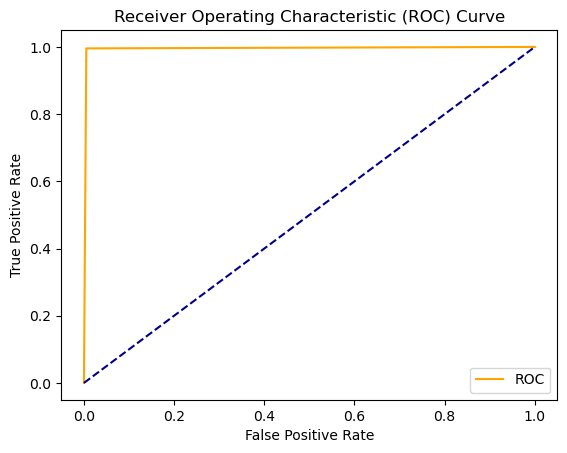

AUC score: 0.99519592872988


In [37]:
# Plot the ROC curve and get the AUC score for LightGBM
plot_roc_curve(clf_gbm)

## Extreme Gradient Boost


In [38]:
# Create an XGBoost classifier object
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',colsample_bytree=0.7, learning_rate=0.4, max_depth=9, n_estimators=170, reg_alpha=0.005,
                          scale_pos_weight=3.3, subsample=0.9, random_state=0, verbosity=0);

# Train XGBoost Classifier
clf_xgb.fit(train_features,train_labels);

In [39]:
# Predict the response for the test dataset
y_pred_xgb = clf_xgb.predict(test_features)
y_pred_xgb

array([1, 1, 1, ..., 1, 1, 0])

In [40]:
# Get the metrics for the XGBoost
print(classification_report(test_labels,y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2101
           1       1.00      1.00      1.00      2287

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [41]:
# Get macro average F1 score
f1_XGB = f1_score(test_labels, y_pred_xgb, average='macro')
f1_XGB

0.9963466974161294

In [42]:
# Calculate Matthews Correlation coefficient
MCC_XGB = matthews_corrcoef(test_labels, y_pred_xgb)
MCC_XGB

0.9926971348363234

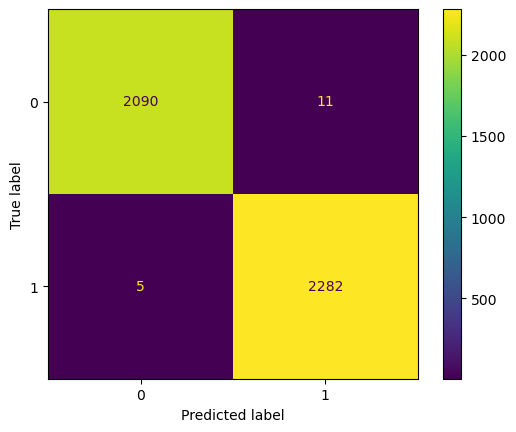

In [43]:
# Plot the confusion matrix for XGBoost
cm=confusion_matrix(test_labels,y_pred_xgb,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

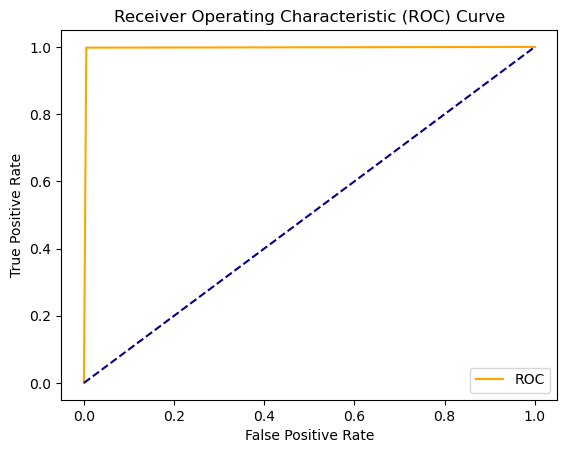

AUC score: 0.9962890638413799


In [44]:
# Plot the ROC curve and get the AUC score for XGBoost
plot_roc_curve(clf_xgb)